In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# This is an EXUDYN example
#
# Details:  Create flexible multibody system
#
# Author:   Johannes Gerstmayr 
# Date:     2021-09-10
# Update:   2024-05-14
# Copyright:This file is part of Exudyn. Exudyn is free software. You can redistribute it and/or modify it under the terms of the Exudyn license. See 'LICENSE.txt' for more details.
#
# pip install webgui_jupyter_widgets
# pip install ngsolve
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Important modules to be imported

In [2]:
import exudyn as exu
from exudyn.utilities import *
from exudyn.FEM import *
import numpy as np
from math import sqrt, sin, cos, pi

doMeshing = True #set false if mesh shall be loaded
computeStresses = True
useHCBmodes = True 
useRoundings = False

fileName = 'testData/FMBStest1' #for load/save of FEM data

# Parameter Definition
![example geometry](CMSexampleCourseBody.png "Geometry")

In [3]:
#flexible body dimensions:
femInterface = FEMinterface()
#geometrical parameters
ri = 0.010 #radius of hole/bolt
ra = 0.016 #outer radius
t  = 0.020 #part thickness, bolt length
f  = 0.004 #radius of part rounding
f2 = 0.002 #radius of bolt rounding
L = 0.250  #distance hole/bolt

hp = ra*sqrt(0.5)-f*(1-sqrt(0.5)) #height of bar
d1 = (ra+1*f)*sqrt(0.5) #length of rounded part
L1 = L-2*d1 #length of rectangular section

#number of eigenmodes
nModes = 8

rho = 1000
Emodulus=1e8
nu=0.3


# Create FEM mesh in Netgen

In [4]:
if doMeshing: #needs netgen/ngsolve to be installed to compute mesh, see e.g.: https://github.com/NGSolve/ngsolve/releases

    import sys

    from netgen.occ import *
    #from ngsolve.webgui import Draw #in Jupyter
    from ngsolve import Mesh, Draw

    #create part geometry
    wp = WorkPlane(gp_Ax3(p=(0,0,-1.5*t), n=Z, h=X))

    wp.Rotate(90).MoveTo(-ra,0).Arc(ra,-135).Arc(f,45).Line(0.5*L1).Line(0.5*L1).Arc(f,45).Arc(ra,-135)
    wp.Arc(ra,-135).Arc(f,45).Line(L1).Arc(f,45).Arc(ra,-135)
    wp.Close().Reverse()

    p1 = wp.Face().Extrude(t)
    
    #bolt:
    wp2 = WorkPlane(Axes(p=(0,0,-0.5*t), n=X, h=Y))
    f22 = np.sqrt(2)*f2
    if useRoundings:
        wp2.MoveTo(0,0).Line(ri+f2).Rotate(180).Arc(f2,-90).Line(t-2*f2).Rotate(45).Line(f22).Rotate(45).Line(ri-f2).Rotate(90).Line(t).Close() #with rounding+chamfer
    else:
        wp2.MoveTo(0,0).LineTo(ri,0).LineTo(ri,t).LineTo(0,t).LineTo(0,0) #without rounding
    axis2 = Axis((0,0,0),Z)
    p2 = wp2.Face().Revolve(axis2,360)

    #hole:
    wp3 = WorkPlane(Axes(p=(L,0,-1.5*t), n=X, h=Y))
    if useRoundings:
        wp3.MoveTo(0,0).Line(ri+f2).Rotate(135).Line(f22).Rotate(-45).Line(t-2*f2).Rotate(-45).Line(f22).Rotate(135).Line(ri+f2).Rotate(90).Line(t).Close() #with rounding
    else:
        wp3.MoveTo(0,0).LineTo(ri,0).LineTo(ri,t).LineTo(0,t).LineTo(0,0) #without rounding
    axis3 = Axis((L,0,0),Z)
    p3 = wp3.Face().Revolve(axis3,360)
    
    p1 = p1 + p2
    p1 = p1 - p3

    geo = OCCGeometry( p1 )

    #Jupyter, webgui, draw geometry
    #NEEDS: pip install webgui_jupyter_widgets
    from netgen.webgui import Draw as DrawGeo
    #DrawGeo(geo.shape) #uncomment to show only geometry
    
    #generate mesh:
    from ngsolve.webgui import Draw
    mesh = Mesh(geo.GenerateMesh(maxh=1.5*2*f2))
    #Jupyter, webgui, draw mesh
    Draw(mesh)




WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

# Import mesh into Exudyn

In [5]:
SC = exu.SystemContainer()
mbs = SC.AddSystem()

[bfM, bfK,fes] = femInterface.ImportMeshFromNGsolve(mesh, density=rho, youngsModulus=Emodulus, 
                                                    poissonsRatio=nu, 
                                                    meshOrder=1) #use meshOrder=2 for higher stress accuracy
print("number of nodes = ", femInterface.NumberOfNodes())

number of nodes =  1373


# Compute eigenmodes (not needed lateron)

In [6]:
# femInterface.ComputeEigenmodesNGsolve(nModes, excludeRigidBodyModes = 6, useSparseSolver = True)
femInterface.ComputeEigenmodesNGsolve (bfM, bfK, nModes, maxEigensolveIterations= 20, excludeRigidBodyModes= 6, verbose= False)
if False: #activate to animate modes
    from exudyn.interactive import AnimateModes
    mbs.Reset()
    cms = ObjectFFRFreducedOrderInterface(femInterface)

    objFFRF = cms.AddObjectFFRFreducedOrder(mbs, positionRef=[0,0,0], 
                                                  initialVelocity=[0,0,0], 
                                                  initialAngularVelocity=[0,0,0],
                                                  color=[0.1,0.9,0.1,1.],
                                                  )
    mbs.Assemble()
    SC.visualizationSettings.nodes.show = False
    SC.visualizationSettings.openGL.showFaceEdges = True
    SC.visualizationSettings.openGL.multiSampling=4
    SC.visualizationSettings.openGL.lineWidth=2
    SC.visualizationSettings.window.renderWindowSize = [1600,1080]

    #%%+++++++++++++++++++++++++++++++++++++++
    SC.visualizationSettings.general.autoFitScene = False #otherwise, model may be difficult to be moved

    nodeNumber = objFFRF['nGenericODE2'] #this is the node with the generalized coordinates
    AnimateModes(SC, mbs, nodeNumber, period=0.1, 
                 scaleAmplitude = 0.02,
                 showTime=False, renderWindowText='Show modes\n',
                 runOnStart=True)

# Define interfaces

In [7]:
pLeft = [0,0,0] #midpoint of bolt
pRight = [L,0,-t] #midpoint of hole
pMid = [0.5*L,hp,-0.5*t] #midpoint of bar
pTip = [L+ra,0,-0.5*t] #midpoint of bar

nMid = femInterface.GetNodeAtPoint(pMid, tolerance=0.01) #tip node (do not use midpoint, as this may not be a mesh node ...)
print("pMid=",pMid,", nMid=",nMid)
nTip = femInterface.GetNodeAtPoint(pTip, tolerance=0.01) #tip node (do not use midpoint, as this may not be a mesh node ...)
print("pTip=",pTip,", nTip=",nTip)

tV = np.array([0,0,0.5*t])
nodesLeft = femInterface.GetNodesOnCylinder(pLeft-tV, pLeft+tV, ri)
#print('nodesLeft=',nodesLeft)
nodesRight = femInterface.GetNodesOnCylinder(pRight-tV, pRight+tV, ri)
#print('nodesRight=',nodesRight)

lenNodesLeft = len(nodesLeft)
weightsNodesLeft = np.array((1./lenNodesLeft)*np.ones(lenNodesLeft))

lenNodesRight = len(nodesRight)
weightsNodesRight = np.array((1./lenNodesRight)*np.ones(lenNodesRight))

boundaryList = [nodesLeft, nodesRight] #second boudary (right plane) not needed ...


pMid= [0.125, 0.010142135623730952, -0.01] , nMid= 251
pTip= [0.266, 0, -0.01] , nTip= 279


# Compute eigenmodes

In [8]:
#remark: ComputeEigenmodes requires upgrade of scipy (python -m pip install --upgrade scipy) as compared to Anaconda installation...
import time
useHCBmodes = True #Hurty-Craig-Bampton modes

print("compute modes... ")
start_time = time.time()

if useHCBmodes:
     femInterface.ComputeHurtyCraigBamptonModes(boundaryNodesList=boundaryList, 
                                   nEigenModes=nModes, 
                                   useSparseSolver=True,
                                   computationMode = HCBstaticModeSelection.RBE2)
#     femInterface.ComputeHurtyCraigBamptonModesNGsolve(bfM, bfK, boundaryNodesList=boundaryList, 
#                                          nEigenModes=nModes, maxEigensolveIterations=20, verbose= True)
else:
    #femInterface.ComputeEigenmodes(nModes, excludeRigidBodyModes = 6, useSparseSolver = True)
    femInterface.ComputeEigenmodesNGsolve(bfK=bfK,bfM=bfM, nModes=nModes, excludeRigidBodyModes = 6)

print("computation of modes needed %.3f seconds" % (time.time() - start_time))
print("eigen freq.=", femInterface.GetEigenFrequenciesHz())





compute modes... 
computation of modes needed 0.157 seconds
eigen freq.= [119.97471972 123.13315618 316.73801677 325.41647046 470.21896085
 571.42154893 596.21024387 650.23906849]


# Compute stresses

In [9]:
femModesName = fileName+'modes'
if useHCBmodes:
    femModesName+='HCB'

varType = exu.OutputVariableType.StressLocal

if computeStresses:
    mat = KirchhoffMaterial(Emodulus, nu, rho)
    print("ComputePostProcessingModes ... (may take a while)")
    start_time = time.time()
    femInterface.ComputePostProcessingModesNGsolve (fes, material=mat)
    SC.visualizationSettings.contour.reduceRange=False
    SC.visualizationSettings.contour.outputVariable = varType
    SC.visualizationSettings.contour.outputVariableComponent = 0 #x-component
    #save modes + stresses
    femInterface.SaveToFile(femModesName)
else:
    femInterface.LoadFromFile(femModesName)
    SC.visualizationSettings.contour.outputVariable = varType
    SC.visualizationSettings.contour.outputVariableComponent = 0 #x-component


ComputePostProcessingModes ... (may take a while)


# Setup flexible body in exudyn

In [10]:
cms = ObjectFFRFreducedOrderInterface(femInterface)

objFFRF = cms.AddObjectFFRFreducedOrder(mbs, positionRef=[0,0,0], 
                                              initialVelocity=[0,0,0], 
                                              initialAngularVelocity=[0,0,0],
                                              color=[0.1,0.9,0.1,1.],
                                              )

# Visualize modes

In [11]:
if True:
    from exudyn.interactive import AnimateModes
    mbs.Assemble()
    SC.visualizationSettings.nodes.show = False
    SC.visualizationSettings.openGL.showFaceEdges = True
    SC.visualizationSettings.openGL.multiSampling=4
    #SC.visualizationSettings.window.renderWindowSize = [1600,1080]
    SC.visualizationSettings.general.autoFitScene = False #otherwise, model may be difficult to be moved

    nodeNumber = objFFRF['nGenericODE2'] #this is the node with the generalized coordinates
    AnimateModes(SC, mbs, nodeNumber, scaleAmplitude = 0.1, runOnStart = True)


# Add gravity

In [12]:
#add gravity (not necessary if user functions used)
oFFRF = objFFRF['oFFRFreducedOrder']
mBody = mbs.AddMarker(MarkerBodyMass(bodyNumber=oFFRF))
mbs.AddLoad(LoadMassProportional(markerNumber=mBody, loadVector= [0,-9.81,0]))

0

# Add joint constraint

In [13]:
#%%+++++++++++++++++++++++++++++++++++++++++++++++++++++
#add markers and joints

oGround = mbs.AddObject(ObjectGround(referencePosition = [0,0,0]))
mGround = mbs.AddMarker(MarkerBodyRigid(bodyNumber = oGround, 
                                        localPosition = pLeft))

mLeft = mbs.AddMarker(MarkerSuperElementRigid(bodyNumber=objFFRF['oFFRFreducedOrder'], 
                                              meshNodeNumbers=np.array(nodesLeft), #these are the meshNodeNumbers
                                              weightingFactors=weightsNodesLeft))
oJoint = mbs.AddObject(GenericJoint(markerNumbers=[mGround, mLeft], 
                           constrainedAxes = [1,1,1,1,1,0],
                           visualization=VGenericJoint(axesRadius=0.05*ri, axesLength=1.5*t)))

#compensate joint offset:
if True:
    mbs.Assemble() #initialize system to compute joint offset
    jointOffset = mbs.GetObjectOutput(oJoint,exu.OutputVariableType.DisplacementLocal)
    print('jointOffset=',jointOffset)

    mbs.SetMarkerParameter(mLeft.GetIndex(), 'offset', list(-jointOffset)) #compensate offset; mLeft.GetIndex() because of BUG751

    mbs.Assemble() #initialize system to compute joint offset
    jointOffset = mbs.GetObjectOutput(oJoint,exu.OutputVariableType.DisplacementLocal)
    print('jointOffset=',jointOffset)


jointOffset= [ 4.25422085e-05 -2.32548186e-04  3.43873720e-05]
jointOffset= [ 1.35525272e-19  1.08420217e-19 -1.15955884e-19]


In [14]:
mLeft

2

# Add sensors

In [15]:
fileDir = 'solution/'
sMidDispl = mbs.AddSensor(SensorSuperElement(bodyNumber=objFFRF['oFFRFreducedOrder'], 
                          meshNodeNumber=nMid, #meshnode number!
                          fileName=fileDir+'uMid'+str(nModes)+'modes.txt', 
                          outputVariableType = exu.OutputVariableType.Displacement))
sTipDispl = mbs.AddSensor(SensorSuperElement(bodyNumber=objFFRF['oFFRFreducedOrder'], 
                          meshNodeNumber=nTip, #meshnode number!
                          fileName=fileDir+'uTip'+str(nModes)+'modes.txt', 
                          outputVariableType = exu.OutputVariableType.Displacement))

# Set up visualization
(not needed)

In [16]:
nodeDrawSize = 0.0025 #for joint drawing
SC.visualizationSettings.nodes.defaultSize = nodeDrawSize
SC.visualizationSettings.nodes.drawNodesAsPoint = False
SC.visualizationSettings.connectors.defaultSize = nodeDrawSize

SC.visualizationSettings.nodes.show = False
SC.visualizationSettings.nodes.showBasis = True #of rigid body node of reference frame
SC.visualizationSettings.nodes.basisSize = t*4
SC.visualizationSettings.bodies.deformationScaleFactor = 1 #use this factor to scale the deformation of modes

SC.visualizationSettings.openGL.showFaceEdges = True
SC.visualizationSettings.openGL.showFaces = True

SC.visualizationSettings.sensors.show = True
SC.visualizationSettings.sensors.drawSimplified = False
SC.visualizationSettings.sensors.defaultSize = nodeDrawSize*2
SC.visualizationSettings.markers.drawSimplified = False
SC.visualizationSettings.markers.show = False
SC.visualizationSettings.markers.defaultSize = nodeDrawSize*2

SC.visualizationSettings.loads.drawSimplified = False
SC.visualizationSettings.loads.defaultSize = t*3
SC.visualizationSettings.loads.defaultRadius = 0.05*t

SC.visualizationSettings.window.renderWindowSize=[1280,720]
SC.visualizationSettings.openGL.multiSampling = 4

#create animation:
# simulationSettings.solutionSettings.recordImagesInterval = 0.005
# SC.visualizationSettings.exportImages.saveImageFileName = "animation/frame"


# Set up simulation

In [17]:
mbs.Assemble() #initialize bodies, assemble system; necessary to simulate

simulationSettings = exu.SimulationSettings()
simulationSettings.solutionSettings.solutionInformation = "ObjectFFRFreducedOrder test"

h=1e-3
tEnd = 2

simulationSettings.timeIntegration.numberOfSteps = int(tEnd/h)
simulationSettings.timeIntegration.endTime = tEnd
simulationSettings.solutionSettings.writeSolutionToFile = True
simulationSettings.solutionSettings.solutionWritePeriod = h
simulationSettings.timeIntegration.verboseMode = 1
#simulationSettings.timeIntegration.verboseModeFile = 3
simulationSettings.timeIntegration.newton.useModifiedNewton = True

simulationSettings.solutionSettings.sensorsWritePeriod = h

simulationSettings.timeIntegration.generalizedAlpha.spectralRadius = 0.8
#simulationSettings.displayStatistics = True
simulationSettings.displayComputationTime = True


# Start renderer and Simulate

In [18]:
lifeVisualization = False

if lifeVisualization:
    SC.visualizationSettings.general.autoFitScene=False #if reloaded view settings
    exu.StartRenderer()
    if 'renderState' in exu.sys: SC.SetRenderState(exu.sys['renderState']) #load last model view
    mbs.WaitForUserToContinue() #press space to continue
        
exu.SolveDynamic(mbs, #solverType=exu.DynamicSolverType.TrapezoidalIndex2, 
                  simulationSettings=simulationSettings)
            
uTip = mbs.GetSensorValues(sMidDispl)
print("nModes=", nModes, ", mid displacement=", uTip)

if lifeVisualization:
    SC.WaitForRenderEngineStopFlag()
    exu.StopRenderer() #safely close rendering window!


+++++++++++++++++++++++++++++++
EXUDYN V1.8.39.dev1 solver: implicit second order time integration
STEP1168, t = 1.168s, timeToGo = 1.42566s, Nit/step = 5.97089
STEP1837, t = 1.837s, timeToGo = 0.355078s, Nit/step = 6.10762
STEP2000, t = 2s, timeToGo = 2.54907e-13s, Nit/step = 5.98773
solver finished after 4.65733 seconds.
CPU-time statistics:
  total time   = 4.66 seconds
  measured time= 4.64 seconds (=99.7%) 
  non-zero timer [__ sub-timer]:
  factorization     = 0.144%
  newtonIncrement   = 0.446%
  integrationFormula= 0.0534%
  ODE2RHS           = 5.91%
  ODE1RHS           = 0.013%
  AERHS             = 26.9%
  totalJacobian     = 4.5%
  __jacobianODE2    = 3.57%
  __jacobianODE1    = 0.00141%
  __jacobianAE      = 0.919%
  massMatrix        = 3.54%
  reactionForces    = 53.5%
  writeSolution     = 4.99%
  overhead          = 0.0325%
  visualization/user= 0.00365%
nModes= 8 , mid displacement= [ 1.17156032e-04 -1.75044632e-03 -7.09745594e-08]


# 3D rendering of FMBS

In [19]:
if True: #use this to reload the solution and use SolutionViewer
    SC.visualizationSettings.general.autoFitScene=False #if reloaded view settings

    mbs.SolutionViewer() #can also be entered in IPython ...


columns imported = [21, 21, 21, 0, 0, 7, 0]
total columns to be imported = 70 , array size of file = 71


# Plot sensor

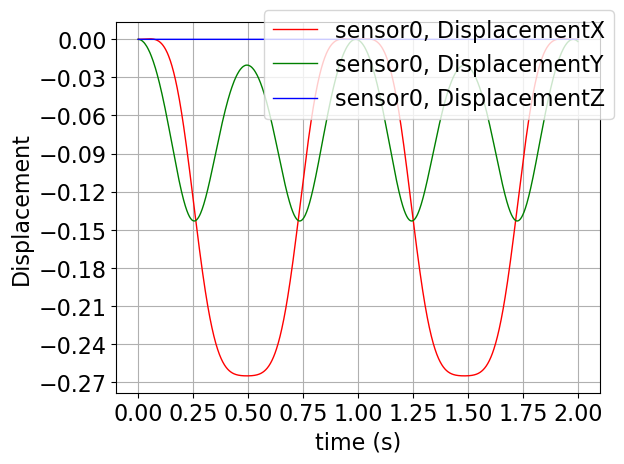

In [21]:
if True:
    mbs.PlotSensor(sensorNumbers=[sMidDispl,sMidDispl,sMidDispl], components=[0,1,2])